In [1]:
import os
import random
from collections import deque
import gym
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from IPython.display import clear_output

Using TensorFlow backend.


In [0]:
env_name = "CartPole-v1"
env = gym.make(env_name)
action_size = env.action_space.n
state_size = env.observation_space.shape[0]
minibatch_size = 128
num_episodes = 2000
output_dir = os.path.join("model_output", env_name)

In [0]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [0]:
class DQNAgent:
    
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000) # Memory used for sampling moves for training
        self.gamma = 0.95                # Discount rate for future rewards
        self.tau = 0.15                  # Multiplier for applying new weights to target model
        self.epsilon = 1.0               # Initial rate for exploration
        self.epsilon_decay = 0.995       # Multiplier for exploration rate
        self.epsilon_min = 0.01          # Minimum exploration rate
        self.learning_rate = 0.005       # NN learning rate
        
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.target_model.set_weights(self.model.get_weights())
    
    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation="relu"))
        model.add(Dense(24, activation="relu"))
        model.add(Dense(self.action_size, activation="linear"))
        model.compile(optimizer=Adam(lr=self.learning_rate), loss="mse")
        return model
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def get_action(self, state):
        # Use random exploration for the current rate.
        if np.random.rand() < self.epsilon:
            return random.randrange(self.action_size)
        
        # Otherwise use the model to predict the rewards and select the max.
        q_values = self.model.predict(state)
        return np.argmax(q_values[0])

    def replay(self, batch_size):
        if len(agent.memory) < minibatch_size:
            return
        
        # Decay the exploration rate.
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon_min, self.epsilon)
            
        minibatch = random.sample(self.memory, minibatch_size)
        
        state_batch, q_values_batch = [], []
        for state, action, reward, next_state, done in minibatch:
            # Get predictions for all actions for the current state.
            q_values = self.model.predict(state)
            
            # If we're not done, add on the future predicted reward at the discounted rate.
            if done:
                q_values[0][action] = reward
            else:
                f = self.target_model.predict(next_state)
                future_reward = max(self.target_model.predict(next_state)[0])
                q_values[0][action] = reward + self.gamma * future_reward
            
            state_batch.append(state[0])
            q_values_batch.append(q_values[0])
            
        # Re-fit the model to move it closer to this newly calculated reward.
        self.model.fit(np.array(state_batch), np.array(q_values_batch), batch_size=batch_size, epochs=1, verbose=0)
           
        self.update_weights()
            
    def update_weights(self):
        weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        
        for i in range(len(target_weights)):
            target_weights[i] = weights[i] * self.tau + target_weights[i] * (1 - self.tau)
            
        self.target_model.set_weights(target_weights)

    def load_weights(self, name):
        self.model.load_weights(name)

    def save_weights(self, name):
        self.model.save_weights(name)

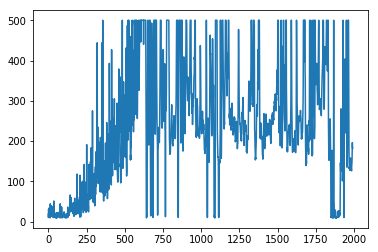

episode: 1991/2000, score: 149.0, eps: 0.01
episode: 1992/2000, score: 148.0, eps: 0.01
episode: 1993/2000, score: 137.0, eps: 0.01
episode: 1994/2000, score: 136.0, eps: 0.01
episode: 1995/2000, score: 138.0, eps: 0.01
episode: 1996/2000, score: 134.0, eps: 0.01
episode: 1997/2000, score: 140.0, eps: 0.01
episode: 1998/2000, score: 161.0, eps: 0.01
episode: 1999/2000, score: 194.0, eps: 0.01


In [17]:
agent = DQNAgent(state_size, action_size)
scores = []

for episode in range(num_episodes):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    score = 0
    
    for frame in range(1000):
        # env.render()
        
        action = agent.get_action(state)
        
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        
        agent.remember(state, action, reward, next_state, done)
    
        state = next_state
        score += reward
        
        if done:
            scores.append(score)
            print("episode: {}/{}, score: {}, eps: {:.2}".format(episode, num_episodes, score, agent.epsilon))
            break
            
    agent.replay(minibatch_size)
    
    if episode % 10 == 0 or episode < 10:
        clear_output(wait=True)
        plt.plot(scores)
        plt.show()
    
    if episode % 100 == 0:
        agent.save_weights(output_dir + "weights_" + '{:04d}'.format(episode) + ".hdf5")